In [3]:
!pip install graphviz

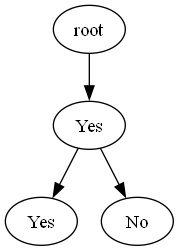

'decision_tree.png'

In [7]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import graphviz
from IPython.display import Image, display

# Load dataset (assumed to be in the same directory as the Jupyter notebook)
df = pd.read_csv('PlayTennis.csv')

# Ensure the 'Play Tennis' column exists in the dataset
if 'Play Tennis' not in df.columns:
    raise ValueError("'Play Tennis' column not found in the dataset. Please check the column name.")

# Update the target column to 'Play Tennis'
target_column = 'Play Tennis'

# Utility functions
def entropy(labels):
    counts = Counter(labels)
    total = len(labels)
    return -sum((count/total) * math.log2(count/total) for count in counts.values())

def info_gain(df, attr, target):
    total_entropy = entropy(df[target])
    values = df[attr].unique()
    weighted_entropy = 0

    for val in values:
        subset = df[df[attr] == val]
        weighted_entropy += (len(subset) / len(df)) * entropy(subset[target])

    return total_entropy - weighted_entropy

def split_info(df, attr):
    counts = df[attr].value_counts(normalize=True)
    return -sum(p * math.log2(p) for p in counts)

def gain_ratio(df, attr, target):
    gain = info_gain(df, attr, target)
    split = split_info(df, attr)
    return gain / split if split != 0 else 0

def best_split_continuous(df, attr, target):
    values = sorted(df[attr].unique())
    best_gain_ratio = -float('inf')
    best_threshold = None
    best_left_split = None
    best_right_split = None

    for i in range(1, len(values)):
        threshold = (values[i - 1] + values[i]) / 2
        left_split = df[df[attr] <= threshold]
        right_split = df[df[attr] > threshold]

        left_entropy = entropy(left_split[target])
        right_entropy = entropy(right_split[target])
        total_entropy = len(left_split) / len(df) * left_entropy + len(right_split) / len(df) * right_entropy
        gain = entropy(df[target]) - total_entropy
        split_info_value = (len(left_split) / len(df)) * math.log2(len(left_split) / len(df)) + (len(right_split) / len(df)) * math.log2(len(right_split) / len(df))
        gain_ratio_value = gain / split_info_value if split_info_value != 0 else 0

        if gain_ratio_value > best_gain_ratio:
            best_gain_ratio = gain_ratio_value
            best_threshold = threshold
            best_left_split = left_split
            best_right_split = right_split

    return best_threshold, best_left_split, best_right_split

# Recursive tree builder
def build_tree(df, target, features):
    labels = df[target]
    
    # Base cases
    if len(set(labels)) == 1:
        return labels.iloc[0]
    if not features:
        return labels.mode()[0]

    # Best attribute selection using gain ratio
    best_attr = None
    best_subtree = None
    best_threshold = None
    if df[features[0]].dtype == 'object':  # Categorical features
        gains = {attr: gain_ratio(df, attr, target) for attr in features}
        best_attr = max(gains, key=gains.get)
        tree = {best_attr: {}}

        for val in df[best_attr].unique():
            sub_df = df[df[best_attr] == val]
            subtree = build_tree(sub_df, target, [f for f in features if f != best_attr])
            tree[best_attr][val] = subtree
    else:  # Continuous features
        best_attr = features[0]
        threshold, left_split, right_split = best_split_continuous(df, best_attr, target)
        if threshold is not None:
            tree = {best_attr: {'<= ' + str(threshold): build_tree(left_split, target, [f for f in features if f != best_attr]),
                                '> ' + str(threshold): build_tree(right_split, target, [f for f in features if f != best_attr])}}
    return tree

# Ensure 'Play Tennis' is excluded from the features list
features = list(df.columns)
if 'Play Tennis' in features:
    features.remove('Play Tennis')

# Build C4.5 tree
decision_tree = build_tree(df, target='Play Tennis', features=features)

# Function to visualize the tree using Graphviz
def visualize_tree(tree, parent_name, graph=None):
    if graph is None:
        graph = graphviz.Digraph(format='png', engine='dot')

    # If the tree is a string (leaf node)
    if isinstance(tree, str):
        graph.node(parent_name, tree)
        return graph

    for key, value in tree.items():
        node_name = f'{parent_name}_{key}'
        graph.node(node_name, key)
        graph.edge(parent_name, node_name)

        if isinstance(value, dict):
            for sub_key, sub_value in value.items():
                visualize_tree(sub_value, node_name, graph)
        else:
            graph.node(f'{node_name}_{value}', value)
            graph.edge(node_name, f'{node_name}_{value}')

    return graph

# Visualize the decision tree
graph = visualize_tree(decision_tree, 'root')

# Save the tree as a PNG image
graph.render('decision_tree')  # This saves the tree as 'decision_tree.png'

# Display the image in the Jupyter notebook
display(Image(filename='decision_tree.png'))

# If you'd like to directly view the Graphviz output in the notebook:
graph.view()  # This opens the PNG in a viewer automatically
